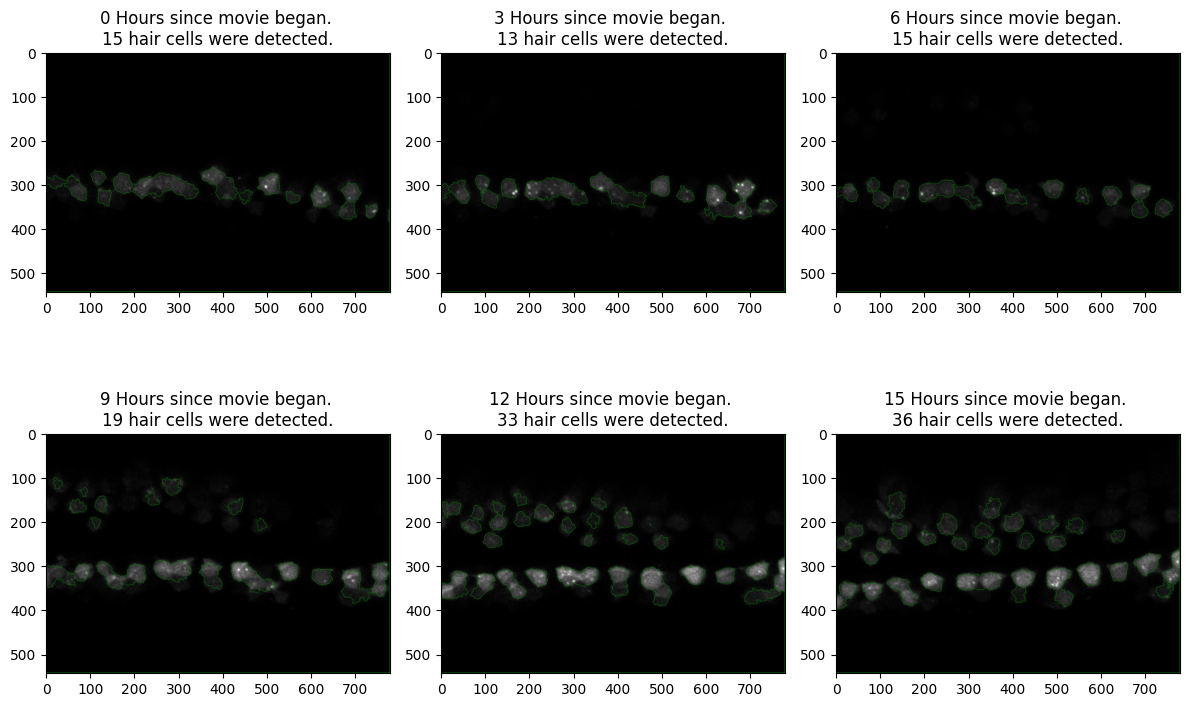

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
import glob
import tifffile as tiff

def convert_to_gs(image):
    '''
    :param image: 2D array.
    :return: gs_image - 2D array image in grayscale values range.
    '''
    #convert to grayscale
    imin = image.min()
    imax = image.max()
    a = 255 / (imax - imin)
    b = 255 - a * imax
    gs_image = (a * image + b).astype(np.uint8)
    return gs_image

def count_cells(img):
    '''
    :param img: 2D array of grayscale image.
    :return: cells_detected. int - number of cells detected in the given image. segmented - original image with marked cells boundaries
    '''

    gray = convert_to_gs(img)
    _, b = np.histogram(gray)
    thresh_value = b[1] * 0.5
    _, th = cv2.threshold(gray, thresh_value, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(th,cv2.MORPH_OPEN,kernel)
    sure_bg = cv2.dilate(opening,kernel)
    sure_bg = np.uint8(sure_bg)
    dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 10
    markers[unknown == 255] = 0
    segmented = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(segmented, markers)
    segmented[markers == -1] = [0, 128, 0]
    regions = measure.regionprops(markers)
    cells_detected = len(regions)

    return cells_detected, segmented

def get_cells_info(frames):
    '''
    :param frames: list of arrays, each array represents a frame from the tiff file
    :return: cells_info - list of cells counted. Each cells_info[i] represents number of cells in frames[i]
            x_axis - array. Each value represents the time (in hours) of frame taken from the tiff file.
            rates - list. Represents the rates (dx/dt) of hair cells appearance in current treatment.
    '''
    cells_info = []
    for i in range(len(frames)):
        n_cells, img_with_marks = count_cells(frames[i])
        frame_time = i * number_of_frames * 0.25
        cells_info.append([img_with_marks, frame_time, n_cells])

    return cells_info

class Tiff_movie():
    def __init__(self, movie_path):
        self.movie_path = movie_path
        movie_tiff = tiff.imread(movie_path)
        self.movie_file = movie_tiff
        self.size = movie_tiff.shape

    def get_frame(self, time, channel):
        try:
            frame = self.movie_file[time][channel]
            return frame
        except IndexError:
            print("Invalid time/channel. Channel max value:{}, time max value:{}".format(self.movie_file.shape[1]-1, self.movie_file.shape[0]-1))
            return None

    def get_every_x_frame(self, channel, x):
        frames = []
        l = self.size[0]
        for i in range(0, l, x):
            frame = self.get_frame(i, channel)
            frames.append(frame)
        return frames

# movies = []
movies_cells_counts = []
threshes = []
all_rates = []
number_of_frames = 12  # each frame is 0.25h
# for filepath in glob.iglob(''/kaggle/input/movies'Movies/*.tif'):
movie = Tiff_movie('/kaggle/input/movies/DMSO - control.tif')
# movies.append(movie)
frames = movie.get_every_x_frame(0, number_of_frames)
cells_info_list = get_cells_info(frames)

subplot_len = int(len(cells_info_list)/2)
images_list = [sublist[0] for sublist in cells_info_list]
frames_time_list = [int(sublist[1]) for sublist in cells_info_list]
number_of_cells_list = [sublist[2] for sublist in cells_info_list]
titles_list = [str(a) + ' Hours since movie began. \n' + str(b) + ' hair cells were detected.' for a, b in zip(frames_time_list, number_of_cells_list)]

fig, axes = plt.subplots(2, subplot_len, figsize=(12, 8))
for i in range(int(len(cells_info_list))):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ax.imshow(images_list[i])
    ax.set_title(titles_list[i])

plt.tight_layout()
plt.show()